In [17]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
sys.path.append(os.path.abspath(os.path.join('..')))

RESULTS_DIR = "../data/results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

sns.set_theme(style="whitegrid", palette="muted")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
fused = pd.read_csv("../data/processed/fused_network.csv", index_col=0)
affinity = np.clip(fused.values, 0, 1)
dist_matrix = 1.0 - affinity
np.fill_diagonal(dist_matrix, 0.0)
print(f"Distance matrix: {dist_matrix.shape}")

Distance matrix: (4142, 4142)


In [19]:
def evaluate_clustering(embedding, labels):
    """Return a dict with clustering quality metrics."""
    mask = labels != -1
    n_clusters = len(set(labels) - {-1})
    n_total = len(labels)
    n_noise = (labels == -1).sum()
    noise_pct = 100 * n_noise / n_total
    assigned_ratio = 1 - n_noise / n_total

    if n_clusters >= 2 and mask.sum() >= 2:
        sil = silhouette_score(embedding[mask], labels[mask])
    else:
        sil = float('nan')

    composite = sil * assigned_ratio if not np.isnan(sil) else 0.0

    return {
        'n_clusters': n_clusters, 'noise_pct': noise_pct,
        'assigned_ratio': assigned_ratio, 'silhouette': sil,
        'composite': composite
    }

## Fase 1 — Sweep di `cluster_dims` (dimensionalità UMAP per clustering)

Il clustering avviene nello spazio UMAP a dimensionalità intermedia, non in 2D.
Cerchiamo la dimensionalità ottimale per separare i cluster mantenendo un buon rapporto segnale/rumore.

In [20]:
dims_values = [3, 5, 7, 10, 15, 20, 30]
default_nn = 15
default_mcs = 20
default_ms = 5

dims_results = []
dims_embeddings = {}

for nd in dims_values:
    reducer = umap.UMAP(n_components=nd, metric='precomputed',
                        n_neighbors=default_nn, random_state=42)
    emb = reducer.fit_transform(dist_matrix)
    dims_embeddings[nd] = emb

    model = hdbscan.HDBSCAN(min_cluster_size=default_mcs, min_samples=default_ms, metric='euclidean')
    labels = model.fit_predict(emb)

    metrics = evaluate_clustering(emb, labels)
    metrics['cluster_dims'] = nd
    dims_results.append(metrics)
    print(f"dims={nd:>3}: {metrics['n_clusters']:>3} clusters, "
          f"noise={metrics['noise_pct']:5.1f}%, sil={metrics['silhouette']:.4f}, "
          f"composite={metrics['composite']:.4f}")

dims_df = pd.DataFrame(dims_results)
best_dims_idx = dims_df['composite'].idxmax()
best_dims = int(dims_df.loc[best_dims_idx, 'cluster_dims'])
print(f"\n>>> Best cluster_dims = {best_dims} (composite = {dims_df.loc[best_dims_idx, 'composite']:.4f})")

/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims=  3:  63 clusters, noise= 25.0%, sil=0.4479, composite=0.3360


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims=  5:  65 clusters, noise= 30.2%, sil=0.4974, composite=0.3471


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims=  7:  73 clusters, noise= 32.6%, sil=0.5164, composite=0.3482


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims= 10:  67 clusters, noise= 33.1%, sil=0.5112, composite=0.3421


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims= 15:  66 clusters, noise= 29.3%, sil=0.4705, composite=0.3326


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims= 20:  62 clusters, noise= 25.8%, sil=0.4530, composite=0.3360


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dims= 30:  66 clusters, noise= 29.7%, sil=0.4878, composite=0.3429

>>> Best cluster_dims = 7 (composite = 0.3482)


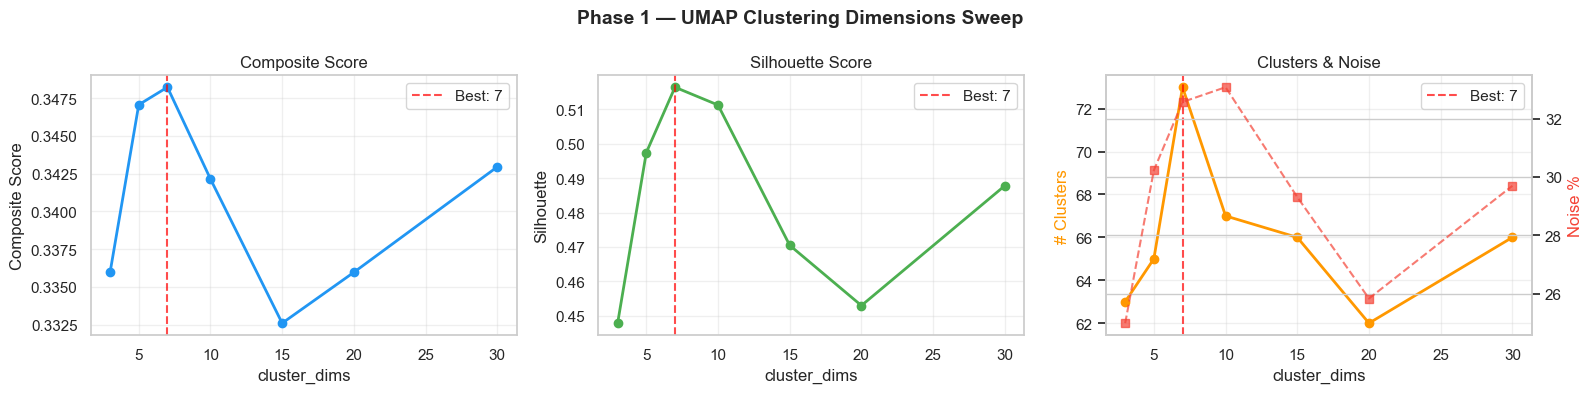

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Phase 1 — UMAP Clustering Dimensions Sweep', fontsize=14, fontweight='bold')

axes[0].plot(dims_df['cluster_dims'], dims_df['composite'], 'o-', color='#2196F3', lw=2)
axes[0].axvline(best_dims, color='red', ls='--', alpha=0.7, label=f'Best: {best_dims}')
axes[0].set_xlabel('cluster_dims'); axes[0].set_ylabel('Composite Score')
axes[0].set_title('Composite Score'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(dims_df['cluster_dims'], dims_df['silhouette'], 'o-', color='#4CAF50', lw=2)
axes[1].axvline(best_dims, color='red', ls='--', alpha=0.7, label=f'Best: {best_dims}')
axes[1].set_xlabel('cluster_dims'); axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette Score'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(dims_df['cluster_dims'], dims_df['n_clusters'], 'o-', color='#FF9800', lw=2)
ax2 = axes[2].twinx()
ax2.plot(dims_df['cluster_dims'], dims_df['noise_pct'], 's--', color='#F44336', lw=1.5, alpha=0.7)
axes[2].axvline(best_dims, color='red', ls='--', alpha=0.7, label=f'Best: {best_dims}')
axes[2].set_xlabel('cluster_dims'); axes[2].set_ylabel('# Clusters', color='#FF9800')
ax2.set_ylabel('Noise %', color='#F44336')
axes[2].set_title('Clusters & Noise'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}tuning_cluster_dims.png", dpi=200, bbox_inches='tight')
plt.show()

## Fase 2 — Sweep di `cluster_n_neighbors` (UMAP n_neighbors per lo spazio di clustering)

Con la dimensionalità ottimale fissata, cerchiamo il valore di n_neighbors che bilancia struttura locale e globale nello spazio di clustering.

In [22]:
nn_values = [5, 10, 15, 20, 30, 50]
nn_results = []
nn_embeddings = {}

for nn in nn_values:
    reducer = umap.UMAP(n_components=best_dims, metric='precomputed',
                        n_neighbors=nn, random_state=42)
    emb = reducer.fit_transform(dist_matrix)
    nn_embeddings[nn] = emb

    model = hdbscan.HDBSCAN(min_cluster_size=default_mcs, min_samples=default_ms, metric='euclidean')
    labels = model.fit_predict(emb)

    metrics = evaluate_clustering(emb, labels)
    metrics['n_neighbors'] = nn
    nn_results.append(metrics)
    print(f"n_neighbors={nn:>3}: {metrics['n_clusters']:>3} clusters, "
          f"noise={metrics['noise_pct']:5.1f}%, sil={metrics['silhouette']:.4f}, "
          f"composite={metrics['composite']:.4f}")

nn_df = pd.DataFrame(nn_results)
best_nn_idx = nn_df['composite'].idxmax()
best_nn = int(nn_df.loc[best_nn_idx, 'n_neighbors'])
print(f"\n>>> Best cluster_n_neighbors = {best_nn} (composite = {nn_df.loc[best_nn_idx, 'composite']:.4f})")

/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=  5:  76 clusters, noise= 22.7%, sil=0.5398, composite=0.4171


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 10:  70 clusters, noise= 24.1%, sil=0.5041, composite=0.3824


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 15:  73 clusters, noise= 32.6%, sil=0.5164, composite=0.3482


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 20:  63 clusters, noise= 30.7%, sil=0.4891, composite=0.3388


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 30:  55 clusters, noise= 37.1%, sil=0.4828, composite=0.3038


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 50:  40 clusters, noise= 41.0%, sil=0.5124, composite=0.3025

>>> Best cluster_n_neighbors = 5 (composite = 0.4171)


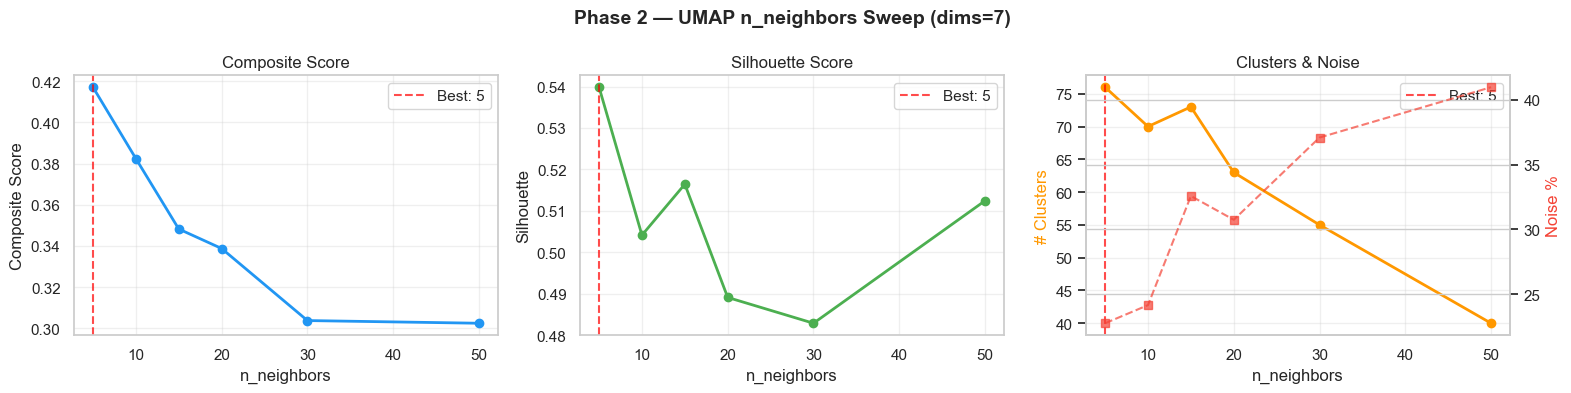

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle(f'Phase 2 — UMAP n_neighbors Sweep (dims={best_dims})', fontsize=14, fontweight='bold')

axes[0].plot(nn_df['n_neighbors'], nn_df['composite'], 'o-', color='#2196F3', lw=2)
axes[0].axvline(best_nn, color='red', ls='--', alpha=0.7, label=f'Best: {best_nn}')
axes[0].set_xlabel('n_neighbors'); axes[0].set_ylabel('Composite Score')
axes[0].set_title('Composite Score'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(nn_df['n_neighbors'], nn_df['silhouette'], 'o-', color='#4CAF50', lw=2)
axes[1].axvline(best_nn, color='red', ls='--', alpha=0.7, label=f'Best: {best_nn}')
axes[1].set_xlabel('n_neighbors'); axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette Score'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(nn_df['n_neighbors'], nn_df['n_clusters'], 'o-', color='#FF9800', lw=2)
ax2 = axes[2].twinx()
ax2.plot(nn_df['n_neighbors'], nn_df['noise_pct'], 's--', color='#F44336', lw=1.5, alpha=0.7)
axes[2].axvline(best_nn, color='red', ls='--', alpha=0.7, label=f'Best: {best_nn}')
axes[2].set_xlabel('n_neighbors'); axes[2].set_ylabel('# Clusters', color='#FF9800')
ax2.set_ylabel('Noise %', color='#F44336')
axes[2].set_title('Clusters & Noise'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}tuning_cluster_n_neighbors.png", dpi=200, bbox_inches='tight')
plt.show()

## Fase 3 — Grid search `min_cluster_size × min_samples`

Con i parametri UMAP ottimali, cerchiamo la migliore configurazione HDBSCAN.

In [24]:
best_embedding = nn_embeddings[best_nn]

mcs_range = list(range(10, 51, 2))
ms_range = [1, 2, 3, 5, 7, 10, 15, 20]

grid_results = []

for mcs in mcs_range:
    for ms in ms_range:
        if ms > mcs:
            continue
        model = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms, metric='euclidean')
        labels = model.fit_predict(best_embedding)
        metrics = evaluate_clustering(best_embedding, labels)
        metrics['min_cluster_size'] = mcs
        metrics['min_samples'] = ms
        grid_results.append(metrics)

grid_df = pd.DataFrame(grid_results)
best_grid_idx = grid_df['composite'].idxmax()
best_row = grid_df.loc[best_grid_idx]
print(f"Best configuration:")
print(f"  min_cluster_size = {int(best_row['min_cluster_size'])}")
print(f"  min_samples      = {int(best_row['min_samples'])}")
print(f"  clusters         = {int(best_row['n_clusters'])}")
print(f"  noise            = {best_row['noise_pct']:.1f}%")
print(f"  silhouette       = {best_row['silhouette']:.4f}")
print(f"  composite        = {best_row['composite']:.4f}")

Best configuration:
  min_cluster_size = 10
  min_samples      = 5
  clusters         = 160
  noise            = 18.2%
  silhouette       = 0.6208
  composite        = 0.5081


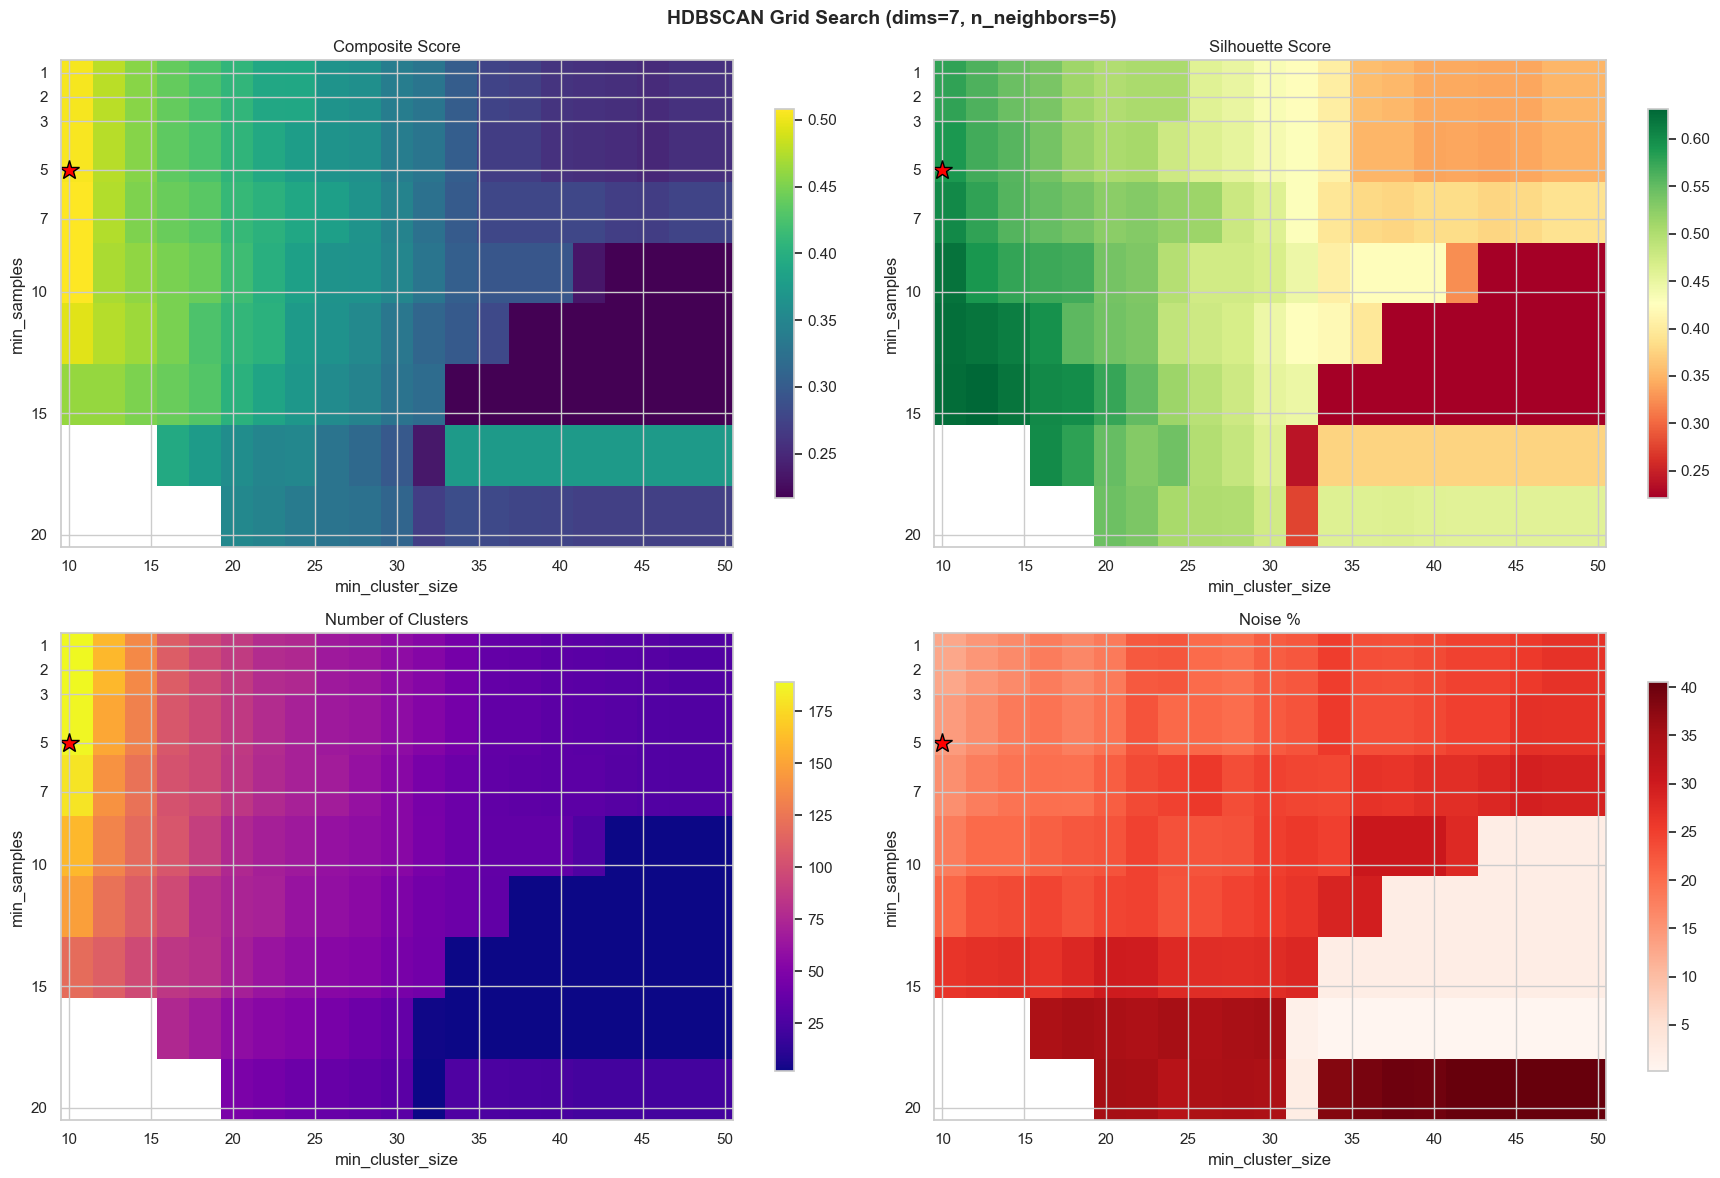

In [25]:
pivot_composite = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                      values='composite', aggfunc='first')
pivot_sil = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                values='silhouette', aggfunc='first')
pivot_nclusters = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                      values='n_clusters', aggfunc='first')
pivot_noise = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                  values='noise_pct', aggfunc='first')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'HDBSCAN Grid Search (dims={best_dims}, n_neighbors={best_nn})',
             fontsize=14, fontweight='bold')

for ax, data, title, cmap in [
    (axes[0, 0], pivot_composite, 'Composite Score', 'viridis'),
    (axes[0, 1], pivot_sil, 'Silhouette Score', 'RdYlGn'),
    (axes[1, 0], pivot_nclusters, 'Number of Clusters', 'plasma'),
    (axes[1, 1], pivot_noise, 'Noise %', 'Reds'),
]:
    im = ax.imshow(data.values, aspect='auto', cmap=cmap,
                   extent=[data.columns.min()-0.5, data.columns.max()+0.5,
                           data.index.max()+0.5, data.index.min()-0.5])
    ax.set_xlabel('min_cluster_size')
    ax.set_ylabel('min_samples')
    ax.set_title(title)
    ax.set_yticks(data.index)
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.plot(best_row['min_cluster_size'], best_row['min_samples'],
            marker='*', color='red', markersize=15, markeredgecolor='black', markeredgewidth=1)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}tuning_hdbscan_grid.png", dpi=200, bbox_inches='tight')
plt.show()

## Fase 4 — EOM vs Leaf

In [26]:
best_mcs = int(best_row['min_cluster_size'])
best_ms = int(best_row['min_samples'])

method_results = []
for method in ['eom', 'leaf']:
    model = hdbscan.HDBSCAN(
        min_cluster_size=best_mcs, min_samples=best_ms,
        cluster_selection_method=method, metric='euclidean'
    )
    labels = model.fit_predict(best_embedding)
    metrics = evaluate_clustering(best_embedding, labels)
    metrics['method'] = method
    method_results.append(metrics)
    print(f"{method.upper():>4}: {metrics['n_clusters']:>3} clusters, "
          f"noise={metrics['noise_pct']:5.1f}%, sil={metrics['silhouette']:.4f}, "
          f"composite={metrics['composite']:.4f}")

method_df = pd.DataFrame(method_results)
best_method = method_df.loc[method_df['composite'].idxmax(), 'method']
print(f"\n>>> Best cluster_selection_method = '{best_method}'")

 EOM: 160 clusters, noise= 18.2%, sil=0.6208, composite=0.5081
LEAF: 176 clusters, noise= 21.5%, sil=0.6287, composite=0.4937

>>> Best cluster_selection_method = 'eom'


## Riepilogo finale

In [27]:
# Run final clustering with best params
final_model = hdbscan.HDBSCAN(
    min_cluster_size=best_mcs, min_samples=best_ms,
    cluster_selection_method=best_method, metric='euclidean'
)
final_labels = final_model.fit_predict(best_embedding)
final_metrics = evaluate_clustering(best_embedding, final_labels)

print("=== Parametri ottimizzati ===")
print(f"UMAP cluster_dims          = {best_dims}")
print(f"UMAP cluster_n_neighbors   = {best_nn}")
print(f"HDBSCAN min_cluster_size   = {best_mcs}")
print(f"HDBSCAN min_samples        = {best_ms}")
print(f"HDBSCAN cluster_selection  = '{best_method}'")
print(f"Clusters found             = {final_metrics['n_clusters']}")
print(f"Noise                      = {final_metrics['noise_pct']:.1f}%")
print(f"Silhouette (excl. noise)   = {final_metrics['silhouette']:.4f}")
print(f"Composite score            = {final_metrics['composite']:.4f}")

=== Parametri ottimizzati ===
UMAP cluster_dims          = 7
UMAP cluster_n_neighbors   = 5
HDBSCAN min_cluster_size   = 10
HDBSCAN min_samples        = 5
HDBSCAN cluster_selection  = 'eom'
Clusters found             = 160
Noise                      = 18.2%
Silhouette (excl. noise)   = 0.6208
Composite score            = 0.5081


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/6m/tldlm3j53p1dhx1qwnp0hkcr0000gn/T/ipykernel_22035/4183289137.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', min(n_clusters, 20))


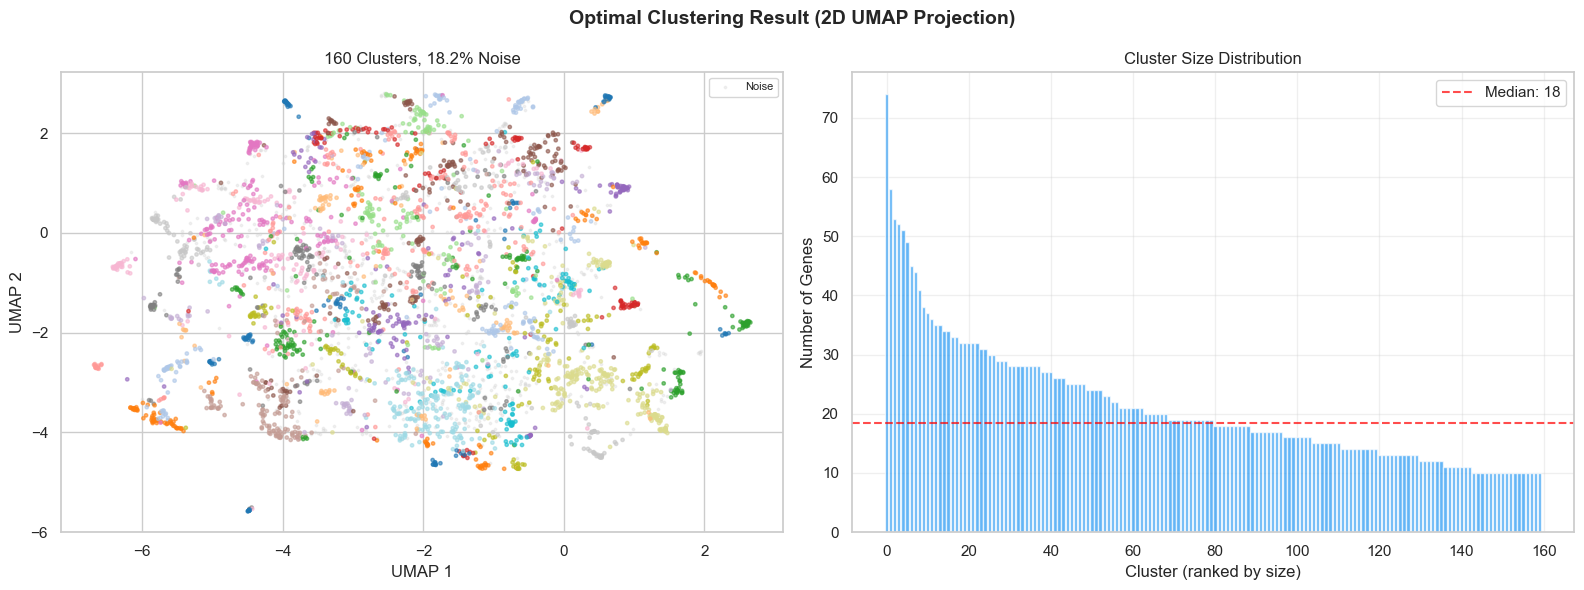

In [28]:
# Project to 2D for visualization of optimal result
viz_reducer = umap.UMAP(n_components=2, metric='precomputed',
                         n_neighbors=15, random_state=42)
viz_emb = viz_reducer.fit_transform(dist_matrix)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Optimal Clustering Result (2D UMAP Projection)', fontsize=14, fontweight='bold')

# Scatter: clusters
mask = final_labels != -1
noise_mask = final_labels == -1

n_clusters = final_metrics['n_clusters']
cmap = plt.cm.get_cmap('tab20', min(n_clusters, 20))

ax = axes[0]
ax.scatter(viz_emb[noise_mask, 0], viz_emb[noise_mask, 1],
           c='lightgray', s=3, alpha=0.3, label='Noise', rasterized=True)
scatter = ax.scatter(viz_emb[mask, 0], viz_emb[mask, 1],
                     c=final_labels[mask], cmap=cmap, s=6, alpha=0.6, rasterized=True)
ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2')
ax.set_title(f'{n_clusters} Clusters, {final_metrics["noise_pct"]:.1f}% Noise')
ax.legend(loc='upper right', fontsize=8)

# Cluster size distribution
ax2 = axes[1]
cluster_sizes = pd.Series(final_labels[mask]).value_counts().sort_values(ascending=False)
ax2.bar(range(len(cluster_sizes)), cluster_sizes.values, color='#2196F3', alpha=0.7)
ax2.set_xlabel('Cluster (ranked by size)'); ax2.set_ylabel('Number of Genes')
ax2.set_title('Cluster Size Distribution')
ax2.axhline(cluster_sizes.median(), color='red', ls='--', alpha=0.7,
            label=f'Median: {cluster_sizes.median():.0f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}tuning_final_result.png", dpi=200, bbox_inches='tight')
plt.show()